# Description

Seek to find the largest value of k up to which linear theory gives accurate results. Such value for kmax is found for each density bin separately. We use Markov Chain Monte Carlo to fit $b1$ and $\beta$. To assert if linear theory is accurate, we compare the inferred $f_0*\sigma_8$ to the true one.

The fitting process is layed out in `Fit_b1_beta_MCMC.ipynb`. Here we use the mock covariance matrix.

For the simple model at hand, the multipoles can be computed analytically via
$$
P_{\ell}(k) = \int_{-1}^{1} \frac{2\ell+1}{2} L_{\ell}(\mu) P^{model}(k,\mu) d\mu, \quad P^{model}(k,\mu) = (1+\beta \mu^2)^2b_1^2P^{matter}_{lin}(k) \exp{(-\frac{1}{2}(\sigma k \mu)^2)}.
$$
where $P^{model}(k,\mu)$ denotes the redshift space power spectrum.

The simplest model is the linear Kaiser law: $P^{model}(k,\mu) = (1+\beta \mu^2)^2b_1^2P^{matter}_{lin}(k)$, leading to:
$$
\begin{align}
    P_0(k) = (1 + \frac{2}{3}\beta + \frac{1}{5}\beta^2 ) b_1^2 P_{lin}(k) \\
    P_2(k) = (\frac{4}{3}\beta + \frac{4}{7}\beta^2) b_1^2 P_{lin}(k).
\end{align}
$$
When including a FoG term:
$$
\begin{align}
    P_0(k) = \frac{1}{2 k^5 \sigma ^5} \left(\sqrt{2 \pi } \text{erf}\left(\frac{k \sigma }{\sqrt{2}}\right) \left(3 \beta ^2+k^4 \sigma ^4+2 \beta  k^2 \sigma ^2\right)+e^{-\frac{1}{2} k^2 \sigma ^2} \left(-2 \beta  (\beta +2) k^3 \sigma ^3-6 \beta ^2 k \sigma \right)\right) b_1^2 P_{lin}(k) \\
    P_2(k) = -\frac{5}{4 k^7 \sigma ^7} \left(\sqrt{2 \pi } \text{erf}\left(\frac{k \sigma }{\sqrt{2}}\right) \left(-45 \beta ^2+k^6 \sigma ^6+(2 \beta -3) k^4 \sigma ^4+3 (\beta -6) \beta  k^2 \sigma ^2\right) \\
    +e^{-\frac{1}{2} k^2 \sigma ^2}\left(2 (2 \beta  (\beta +2)+3) k^5 \sigma ^5+12 \beta  (2 \beta +3) k^3 \sigma ^3+90 \beta ^2 k \sigma \right) \right) b_1^2 P_{lin}.
\end{align}
$$



In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import legendre, erf
from datetime import timedelta
import time

import inv_cov_funcs as icf
import cat_power_algos as catpk
import classylss
import fitsio
import zeus 
from nbodykit.lab import *
from nbodykit import style
plt.style.use(style.notebook)

In [3]:
LOS = [0,0,1]
redshift = 0
BoxSize = 2000
cosmo_paras = classylss.load_ini('/home/jwack/main/Planck18_LCDM.ini')
cosmo = cosmology.cosmology.Cosmology.from_dict(cosmo_paras)
Plin = cosmology.LinearPower(cosmo, redshift, transfer='CLASS')
sigma8_lin = Plin.sigma8
sigma8_true = 0.8111 
f0_true = cosmo.scale_independent_growth_rate(redshift)

dk = 0.01
ells = [0,2]
damped = False # choice of model

/home/jwack/.conda/envs/nbodykit-env/lib/python3.8/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): sigma_8
  self.engine = ClassEngine(pars)


In [4]:
# load computed power spectra to deduce multipoles in each bin and P(k,mu) from data
k_full, shotnoise, n_ptile, Pk_ells_full = icf.load_power_data('/home/jwack/main/fit_linear_model_in_density_bins/', 
                                                               ells, get_data_Pkmus=False)
# for given BoxSize, k is NaN above 0.034
possible_kmax = k_full[k_full<=0.343][1:] # ignore first k bin 

In [5]:
def logprior(theta, i, damped):
    ''' The natural logarithm of the prior probability. Assume parameters independent such that log priors add.
    When damped is True, also fit FoG parameter
    Note that normalization is irrelevant for MCMC.'''
    lp = 0.
    if damped:
        b1, beta, sigma = theta
        sigma_min, sigma_max = 1, 5
        lp_sigma = 0. if sigma_min < sigma < sigma_max else -np.inf
    else:
        b1, beta = theta
        lp_sigma = 0
        
    b1_min, b1_max = 0, 3
    if i == 0:
        beta_min, beta_max = -3, 3
    else:
        beta_min, beta_max = 0, 3
        
    lp_b1 = 0. if b1_min < b1 < b1_max else -np.inf
    lp_beta = 0. if beta_min < beta < beta_max else -np.inf
    
    return lp_b1 + lp_beta + lp_sigma


def loglike(theta, data_multipoles, k, C_inv, damped):
    '''Return logarithm of likelihood i.e. -0.5*chi2.
    data_multipoles must be an array of shape (len(ells), len(k)). theta is parameter vector: [b1, beta, sigma].'''
    ells = [0,2]
    model_multipoles = np.empty((len(ells), len(k)))

    if damped:
        b1, beta, sigma = theta
        model_multipoles[0] = ( 1/(2*(k*sigma)**5) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(3*beta**2+(k*sigma)**4+2*beta*(k*sigma)**2) + 
                                                    np.exp(-0.5*(k*sigma)**2)*(-2*beta*(beta+2)*(k*sigma)**3-6*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
        model_multipoles[1] = ( -5/(4*(k*sigma)**7) * (np.sqrt(2*np.pi)*erf(k*sigma/np.sqrt(2))*(-45*beta**2+(k*sigma)**6+(2*beta-3)*(k*sigma)**4+3*(beta-6)*beta*(k*sigma)**2) + 
                                                    np.exp(-0.5*(k*sigma)**2)*((4*beta*(beta+2)+6)*(k*sigma)**5+12*beta*(2*beta+3)*(k*sigma)**3+90*beta**2*k*sigma) ) ) * b1**2 * Plin(k)
    else:
        b1, beta = theta
        model_multipoles[0] = (1 + 2/3*beta + 1/5*beta**2) * b1**2 * Plin(k)
        model_multipoles[1] = (4/3*beta + 4/7*beta**2) * b1**2 * Plin(k)

    D_M = (data_multipoles - model_multipoles).flatten()
    
    return -0.5*D_M@(C_inv @ D_M)


def logpost(theta, i, data_multipoles, k, C_inv, damped):
    '''Returns the logarithm of the posterior. By Bayes' theorem, this is just the sum of the log prior and log likelihood (up 
    to a irrelavant constant).
    Uses values for theta from pre-analysis step to inform prior
    ''' 
    return logprior(theta, i, damped) + loglike(theta, data_multipoles, k, C_inv, damped)

In [11]:
# set range of kmax for which we compute delta_fs8 for each density bin. 
# exclude taking lowested k bin as kmax since that bin will be removed in slicing (negative quadrupole)
kmax_range = possible_kmax[1:11]
Nkmax = len(kmax_range)

chains = np.empty((n_ptile, Nkmax), dtype='object')

b1_fits, beta_fits, sigma_fits, delta_fs8 = np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan) 
b1_stds, beta_stds, sigma_stds, delta_fs8_stds = np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan), np.full((n_ptile, Nkmax), np.nan)
reduced_chi2 = np.full((n_ptile, Nkmax), np.nan)

nsteps = 2500

if damped == True:
    ndim = 3
    nwalkers = 8 
    start_b1 = 0.5 + 1*np.random.random(nwalkers)
    start_beta = 0.5 + 1*np.random.random(nwalkers)
    start_sigma = 5 + 4*np.random.random(nwalkers) 
    start = np.column_stack([start_b1, start_beta, start_sigma])
else:
    ndim = 2
    nwalkers = 6 
    start_b1 = 0.5 + 1*np.random.random(nwalkers)
    start_beta = 0.5 + 1*np.random.random(nwalkers)
    start = np.column_stack([start_b1, start_beta])


print("Fitting up to kmax=%.3f"%kmax_range[-1])

for i in range(n_ptile):
    cov_mat = np.loadtxt('/home/jwack/main/bruteforce_covmat/covariance_matricies/cov_ptile_%d.txt'%i)
    t1 = time.time()
    for j,kmax in enumerate(kmax_range):
        # slice up to increasingly large kmax and find delta_fs8 for each bin
        mask = np.full(len(k_full), False)
        mask = k_full <= kmax
        mask[0] = False 
        k_sliced = k_full[mask]
        Pk_ells_i = Pk_ells_full[:,:,mask][i]
        
        C_inv = icf.mock_cov_mat_inv(cov_mat, k_full, kmax)
        sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=False, args=[i, Pk_ells_i, k_sliced, C_inv, damped]) 
        sampler.run_mcmc(start, nsteps)
        
        chain = sampler.get_chain(flat=True, discard=nsteps//2)
        chains[i][j] = chain # only needed when wanting to investigate chains later on
        
        b1_fits[i][j], b1_stds[i][j] = np.mean(chain[:,0]), np.std(chain[:,0]) 
        # parameter space is sym about b1=0 for Kaiser model. To get non negative fs8 assure that b1 and beta have the same sign
        if i == 0:
            b1_fits[i][j] *= -1
        beta_fits[i][j], beta_stds[i][j] = np.mean(chain[:,1]), np.std(chain[:,1])
        delta_fs8[i][j] = 1 - sigma8_lin*(beta_fits[i][j]*b1_fits[i][j])/(f0_true*sigma8_true)
        delta_fs8_stds[i][j] = np.abs(sigma8_lin/(f0_true*sigma8_true)*(beta_stds[i][j]*b1_fits[i][j]+beta_fits[i][j]*b1_stds[i][j]))        
        if damped:
            sigma_fits[i][j], sigma_stds[i][j] = np.mean(chain[:,2]), np.std(chain[:,2])
            reduced_chi2[i][j] = -2*loglike([b1_fits[i][j], beta_fits[i][j], sigma_fits[i][j]], Pk_ells_i, k_sliced, C_inv, damped) / (len(ells)*len(k_sliced)-ndim)
        else:
            reduced_chi2[i][j] = -2*loglike([b1_fits[i][j], beta_fits[i][j]], Pk_ells_i, k_sliced, C_inv, damped) / (len(ells)*len(k_sliced)-ndim)
            
    t2 = time.time()
    print('Fitted %d-th percentile in %s'%(i,str(timedelta(seconds=t2-t1))))

Fitting up to kmax=0.115



Sampling progress :  20%|████████████▏                                               | 507/2500 [00:07<00:25, 78.77it/s]


Sampling progress :  43%|█████████████████████████▎                                 | 1075/2500 [00:15<00:18, 77.43it/s]


Sampling progress :  67%|███████████████████████████████████████▎                   | 1666/2500 [00:23<00:11, 72.17it/s]


Sampling progress :  90%|████████████████████████████████████████████████████▊      | 2238/2500 [00:31<00:04, 64.28it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:34<00:00, 71.57it/s]

Sampling progress :  12%|███████                                                     | 293/2500 [00:04<00:33, 65.77it/s]


Sampling progress :  34%|████████████████████▌                                       | 855/2500 [00:12<00:18, 89.91it/s]


Sampling progress :  56%|████████████████████████████████▊                          | 1393/2500 [00:20<00:20, 53.79it/s]


Sampling progress :  79%|██████████████████████████████████████████████▎            | 1964/2500 [00:28<00:07, 69.19it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:36<00:00, 69.17it/s]

Sampling progress :   0%|▎                                                            | 12/2500 [00:00<01:34, 26.20it/s]


Sampling progress :  23%|██████████████                                              | 586/2500 [00:08<00:24, 77.56it/s]


Sampling progress :  48%|████████████████████████████                               | 1191/2500 [00:15<00:15, 83.49it/s]


Sampling progress :  73%|██████████████████████████████████████████▉                | 1822/2500 [00:23<00:08, 75.98it/s]


Sampling progress :  94%|███████████████████████████████████████████████████████▋   | 2362/2500 [00:31<00:01, 79.18it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:33<00:00, 75.24it/s]

Sampling progress :  15%|████████▉                                                   | 371/2500 [00:06<00:38, 55.60it/s]


Sampling progress :  33%|████████████████████                                        | 836/2500 [00:14<00:26, 63.21it/s]


Sampling progress :  51%|██████████████████████████████                             | 1273/2500 [00:23<00:23, 52.94it/s]


Sampling progress :  71%|█████████████████████████████████████████▋                 | 1765/2500 [00:30<00:10, 72.14it/s]


Sampling progress :  89%|████████████████████████████████████████████████████▋      | 2230/2500 [00:39<00:04, 54.48it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:44<00:00, 56.13it/s]

Sampling progress :   6%|███▊                                                        | 157/2500 [00:05<00:33, 69.66it/s]


Sampling progress :  32%|███████████████████▏                                        | 801/2500 [00:13<00:18, 90.59it/s]


Sampling progress :  54%|███████████████████████████████▋                           | 1343/2500 [00:21<00:15, 76.86it/s]


Sampling progress :  79%|██████████████████████████████████████████████▎            | 1964/2500 [00:28<00:06, 87.64it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:36<00:00, 68.37it/s]

Sampling progress :   1%|▍                                                            | 18/2500 [00:00<01:16, 32.45it/s]


Sampling progress :  19%|███████████▏                                                | 466/2500 [00:08<00:37, 54.38it/s]


Sampling progress :  36%|█████████████████████▊                                      | 907/2500 [00:17<00:36, 43.85it/s]


Sampling progress :  51%|█████████████████████████████▊                             | 1263/2500 [00:25<00:27, 44.31it/s]


Sampling progress :  70%|█████████████████████████████████████████                  | 1739/2500 [00:34<00:11, 63.57it/s]


Sampling progress :  89%|████████████████████████████████████████████████████▌      | 2229/2500 [00:42<00:03, 81.12it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:48<00:00, 51.51it/s]

Sampling progress :   4%|██▍                                                         | 100/2500 [00:03<01:09, 34.77it/s]


Sampling progress :  15%|████████▊                                                   | 368/2500 [00:13<01:09, 30.52it/s]


Sampling progress :  26%|███████████████▌                                            | 651/2500 [00:22<00:48, 38.07it/s]


Sampling progress :  38%|███████████████████████                                     | 959/2500 [00:31<01:21, 19.00it/s]


Sampling progress :  51%|█████████████████████████████▉                             | 1269/2500 [00:40<00:26, 46.03it/s]


Sampling progress :  62%|████████████████████████████████████▋                      | 1555/2500 [00:49<00:37, 25.15it/s]


Sampling progress :  72%|██████████████████████████████████████████▎                | 1795/2500 [00:58<00:31, 22.64it/s]


Sampling progress :  82%|████████████████████████████████████████████████▌          | 2056/2500 [01:07<00:16, 26.16it/s]


Sampling progress :  94%|███████████████████████████████████████████████████████▎   | 2342/2500 [01:16<00:04, 32.39it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [01:22<00:00, 30.19it/s]

Sampling progress :   4%|██▍                                                         | 102/2500 [00:03<00:59, 40.36it/s]


Sampling progress :  27%|████████████████▎                                           | 681/2500 [00:11<00:25, 71.71it/s]


Sampling progress :  44%|██████████████████████████▏                                | 1111/2500 [00:19<00:27, 50.10it/s]


Sampling progress :  62%|████████████████████████████████████▍                      | 1544/2500 [00:27<00:16, 57.33it/s]


Sampling progress :  79%|██████████████████████████████████████████████▌            | 1972/2500 [00:35<00:06, 77.21it/s]


Sampling progress :  96%|████████████████████████████████████████████████████████▋  | 2403/2500 [00:43<00:01, 53.63it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:45<00:00, 55.02it/s]

Sampling progress :  11%|██████▌                                                     | 273/2500 [00:06<00:46, 48.38it/s]


Sampling progress :  26%|███████████████▍                                            | 645/2500 [00:13<00:36, 50.65it/s]


Sampling progress :  47%|███████████████████████████▌                               | 1168/2500 [00:21<00:16, 82.60it/s]


Sampling progress :  67%|███████████████████████████████████████▋                   | 1680/2500 [00:29<00:14, 55.76it/s]


Sampling progress :  89%|████████████████████████████████████████████████████▋      | 2235/2500 [00:37<00:03, 70.57it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:40<00:00, 62.21it/s]

Sampling progress :  13%|███████▌                                                    | 316/2500 [00:04<00:28, 76.18it/s]


Sampling progress :  32%|███████████████████▎                                        | 806/2500 [00:11<00:21, 78.52it/s]


Sampling progress :  52%|██████████████████████████████▌                            | 1295/2500 [00:19<00:23, 51.52it/s]


Sampling progress :  68%|████████████████████████████████████████                   | 1697/2500 [00:29<00:15, 51.70it/s]


Sampling progress :  85%|██████████████████████████████████████████████████▎        | 2134/2500 [00:37<00:07, 51.59it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:43<00:00, 57.30it/s]


Fitted 0-th percentile in 446.17 sec



Sampling progress :  25%|██████████████▋                                            | 623/2500 [00:07<00:18, 103.25it/s]


Sampling progress :  52%|██████████████████████████████▎                           | 1305/2500 [00:15<00:10, 113.39it/s]


Sampling progress :  71%|█████████████████████████████████████████▉                 | 1779/2500 [00:23<00:11, 60.78it/s]


Sampling progress :  92%|██████████████████████████████████████████████████████▏    | 2296/2500 [00:31<00:03, 57.28it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:34<00:00, 71.44it/s]

Sampling progress :   9%|█████▏                                                      | 214/2500 [00:05<00:48, 46.81it/s]


Sampling progress :  25%|██████████████▉                                             | 623/2500 [00:13<00:34, 54.40it/s]


Sampling progress :  51%|██████████████████████████████▎                            | 1282/2500 [00:20<00:14, 81.53it/s]


Sampling progress :  77%|█████████████████████████████████████████████▌             | 1933/2500 [00:28<00:05, 95.77it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:34<00:00, 72.15it/s]

Sampling progress :   5%|██▉                                                        | 124/2500 [00:01<00:21, 108.87it/s]


Sampling progress :  34%|████████████████████▏                                       | 840/2500 [00:09<00:19, 85.17it/s]


Sampling progress :  56%|█████████████████████████████████▎                         | 1409/2500 [00:17<00:18, 58.84it/s]


Sampling progress :  75%|████████████████████████████████████████████▍              | 1881/2500 [00:24<00:10, 60.86it/s]


Sampling progress :  95%|███████████████████████████████████████████████████████▉   | 2368/2500 [00:32<00:02, 58.64it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:34<00:00, 71.64it/s]

Sampling progress :  18%|██████████▎                                                | 438/2500 [00:05<00:19, 106.57it/s]


Sampling progress :  44%|██████████████████████████▏                                | 1109/2500 [00:13<00:23, 59.60it/s]


Sampling progress :  64%|█████████████████████████████████████▊                     | 1600/2500 [00:21<00:18, 48.22it/s]


Sampling progress :  85%|██████████████████████████████████████████████████▎        | 2134/2500 [00:29<00:06, 52.53it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:35<00:00, 71.03it/s]

Sampling progress :   5%|███▏                                                        | 133/2500 [00:03<00:35, 66.39it/s]


Sampling progress :  23%|█████████████▊                                              | 574/2500 [00:11<00:34, 55.91it/s]


Sampling progress :  43%|█████████████████████████▎                                 | 1073/2500 [00:19<00:24, 59.40it/s]


Sampling progress :  64%|█████████████████████████████████████▋                     | 1598/2500 [00:27<00:17, 52.91it/s]


Sampling progress :  85%|██████████████████████████████████████████████████▏        | 2126/2500 [00:35<00:06, 61.13it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:41<00:00, 60.50it/s]

Sampling progress :   4%|██▏                                                          | 90/2500 [00:02<00:48, 49.97it/s]


Sampling progress :  19%|███████████▌                                                | 481/2500 [00:09<00:37, 53.17it/s]


Sampling progress :  37%|██████████████████████▍                                     | 937/2500 [00:17<00:17, 89.60it/s]


Sampling progress :  63%|█████████████████████████████████████▎                     | 1580/2500 [00:25<00:12, 72.11it/s]


Sampling progress :  92%|██████████████████████████████████████████████████████     | 2293/2500 [00:32<00:02, 93.66it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:34<00:00, 71.64it/s]

Sampling progress :  19%|███████████▎                                                | 472/2500 [00:05<00:20, 98.59it/s]


Sampling progress :  44%|██████████████████████████                                 | 1105/2500 [00:12<00:21, 63.62it/s]


Sampling progress :  72%|█████████████████████████████████████████▋                | 1796/2500 [00:20<00:06, 102.91it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:27<00:00, 90.78it/s]



Sampling progress :  27%|████████████████                                            | 668/2500 [00:07<00:20, 88.75it/s]


Sampling progress :  55%|████████████████████████████████▋                          | 1383/2500 [00:14<00:11, 99.43it/s]


Sampling progress :  83%|████████████████████████████████████████████████▉          | 2072/2500 [00:21<00:05, 79.12it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:26<00:00, 94.86it/s]

Sampling progress :   7%|████▏                                                       | 177/2500 [00:02<00:28, 82.41it/s]


Sampling progress :  30%|██████████████████▎                                         | 762/2500 [00:10<00:27, 64.24it/s]


Sampling progress :  54%|███████████████████████████████▌                           | 1338/2500 [00:17<00:12, 93.33it/s]


Sampling progress :  76%|█████████████████████████████████████████████              | 1911/2500 [00:24<00:07, 76.97it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:31<00:00, 78.28it/s]

Sampling progress :   0%|                                                                      | 0/2500 [00:00<?, ?it/s]


Sampling progress :  24%|██████████████▏                                             | 590/2500 [00:07<00:23, 81.25it/s]


Sampling progress :  48%|████████████████████████████▌                              | 1208/2500 [00:14<00:15, 81.48it/s]


Sampling progress :  72%|██████████████████████████████████████████▋                | 1807/2500 [00:21<00:09, 74.29it/s]


Sampling progress :  98%|█████████████████████████████████████████████████████████▋ | 2443/2500 [00:29<00:00, 91.90it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:29<00:00, 83.91it/s]


Fitted 1-th percentile in 331.98 sec



Sampling progress :  33%|███████████████████▍                                       | 825/2500 [00:07<00:13, 120.47it/s]


Sampling progress :  68%|███████████████████████████████████████▍                  | 1701/2500 [00:14<00:06, 129.49it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 121.82it/s]

Sampling progress :   3%|█▊                                                          | 73/2500 [00:00<00:21, 111.45it/s]


Sampling progress :  35%|████████████████████▍                                      | 866/2500 [00:07<00:15, 108.30it/s]


Sampling progress :  66%|██████████████████████████████████████▋                    | 1638/2500 [00:15<00:08, 97.89it/s]


Sampling progress :  98%|█████████████████████████████████████████████████████████ | 2459/2500 [00:22<00:00, 111.66it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 109.37it/s]

Sampling progress :  29%|████████████████▉                                          | 717/2500 [00:06<00:15, 118.09it/s]


Sampling progress :  60%|██████████████████████████████████▊                       | 1503/2500 [00:14<00:08, 118.54it/s]


Sampling progress :  92%|█████████████████████████████████████████████████████▎    | 2299/2500 [00:21<00:01, 117.06it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:23<00:00, 108.19it/s]

Sampling progress :  23%|█████████████▋                                             | 579/2500 [00:05<00:17, 109.66it/s]


Sampling progress :  57%|████████████████████████████████▊                         | 1413/2500 [00:12<00:08, 121.84it/s]


Sampling progress :  90%|████████████████████████████████████████████████████▎     | 2257/2500 [00:19<00:02, 116.32it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 113.49it/s]

Sampling progress :  22%|████████████▊                                              | 543/2500 [00:04<00:16, 115.13it/s]


Sampling progress :  54%|███████████████████████████████▎                          | 1350/2500 [00:11<00:10, 113.08it/s]


Sampling progress :  86%|██████████████████████████████████████████████████▏       | 2161/2500 [00:19<00:02, 113.63it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 112.22it/s]

Sampling progress :  18%|██████████▌                                                | 449/2500 [00:03<00:16, 122.05it/s]


Sampling progress :  51%|█████████████████████████████▋                            | 1282/2500 [00:11<00:10, 111.53it/s]


Sampling progress :  83%|████████████████████████████████████████████████▎         | 2081/2500 [00:18<00:03, 122.26it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 114.04it/s]

Sampling progress :  16%|█████████▎                                                 | 394/2500 [00:03<00:18, 115.51it/s]


Sampling progress :  48%|███████████████████████████▋                              | 1193/2500 [00:10<00:12, 101.68it/s]


Sampling progress :  78%|██████████████████████████████████████████████▏            | 1955/2500 [00:17<00:06, 84.93it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 109.12it/s]

Sampling progress :   9%|█████▏                                                     | 220/2500 [00:02<00:21, 108.24it/s]


Sampling progress :  40%|███████████████████████▌                                   | 999/2500 [00:09<00:14, 103.94it/s]


Sampling progress :  70%|████████████████████████████████████████▍                 | 1742/2500 [00:16<00:06, 109.78it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:23<00:00, 105.89it/s]

Sampling progress :   0%|▏                                                             | 8/2500 [00:00<00:37, 66.77it/s]


Sampling progress :  25%|██████████████▊                                             | 616/2500 [00:07<00:22, 83.43it/s]


Sampling progress :  51%|█████████████████████████████▉                             | 1266/2500 [00:15<00:14, 87.52it/s]


Sampling progress :  76%|████████████████████████████████████████████▉              | 1905/2500 [00:22<00:07, 78.28it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:29<00:00, 83.94it/s]

Sampling progress :   1%|▌                                                            | 24/2500 [00:00<01:23, 29.58it/s]


Sampling progress :  24%|██████████████▌                                             | 608/2500 [00:08<00:23, 80.31it/s]


Sampling progress :  49%|████████████████████████████▋                              | 1215/2500 [00:15<00:16, 80.25it/s]


Sampling progress :  72%|██████████████████████████████████████████▋                | 1809/2500 [00:23<00:09, 71.89it/s]


Sampling progress :  97%|█████████████████████████████████████████████████████████▏ | 2424/2500 [00:30<00:01, 70.50it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:31<00:00, 79.12it/s]


Fitted 2-th percentile in 240.70 sec



Sampling progress :  34%|████████████████████                                       | 850/2500 [00:07<00:13, 122.06it/s]


Sampling progress :  70%|████████████████████████████████████████▍                 | 1745/2500 [00:14<00:05, 126.00it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 123.34it/s]

Sampling progress :   7%|███▉                                                       | 166/2500 [00:01<00:17, 132.26it/s]


Sampling progress :  44%|█████████████████████████▋                                | 1107/2500 [00:08<00:10, 131.44it/s]


Sampling progress :  81%|██████████████████████████████████████████████▉           | 2021/2500 [00:15<00:03, 132.19it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 128.09it/s]

Sampling progress :  16%|█████████▎                                                 | 397/2500 [00:03<00:18, 115.16it/s]


Sampling progress :  53%|██████████████████████████████▌                           | 1320/2500 [00:10<00:08, 139.20it/s]


Sampling progress :  88%|███████████████████████████████████████████████████▏      | 2208/2500 [00:18<00:02, 137.00it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 122.98it/s]

Sampling progress :  24%|█████████████▉                                             | 591/2500 [00:04<00:14, 132.96it/s]


Sampling progress :  60%|██████████████████████████████████▉                       | 1506/2500 [00:12<00:07, 125.10it/s]


Sampling progress :  95%|███████████████████████████████████████████████████████▎  | 2384/2500 [00:19<00:00, 121.56it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 124.65it/s]

Sampling progress :  30%|█████████████████▊                                         | 755/2500 [00:06<00:14, 121.36it/s]


Sampling progress :  67%|██████████████████████████████████████▊                   | 1674/2500 [00:13<00:06, 129.12it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 125.34it/s]

Sampling progress :   2%|█                                                            | 45/2500 [00:00<00:25, 94.60it/s]


Sampling progress :  36%|█████████████████████▍                                     | 907/2500 [00:07<00:13, 116.03it/s]


Sampling progress :  69%|████████████████████████████████████████▏                 | 1734/2500 [00:15<00:06, 119.48it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 115.81it/s]

Sampling progress :   2%|█▏                                                          | 52/2500 [00:00<00:23, 104.50it/s]


Sampling progress :  36%|█████████████████████                                      | 893/2500 [00:07<00:13, 118.94it/s]


Sampling progress :  69%|███████████████████████████████████████▊                  | 1717/2500 [00:14<00:06, 117.78it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 117.13it/s]

Sampling progress :   2%|█                                                           | 46/2500 [00:00<00:23, 103.89it/s]


Sampling progress :  32%|███████████████████                                         | 794/2500 [00:07<00:17, 96.87it/s]


Sampling progress :  62%|████████████████████████████████████▏                     | 1560/2500 [00:14<00:08, 109.82it/s]


Sampling progress :  92%|██████████████████████████████████████████████████████▍    | 2307/2500 [00:22<00:01, 99.34it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:24<00:00, 103.40it/s]

Sampling progress :  21%|████████████▌                                              | 532/2500 [00:05<00:17, 112.61it/s]


Sampling progress :  51%|█████████████████████████████▋                            | 1279/2500 [00:12<00:11, 105.31it/s]


Sampling progress :  81%|██████████████████████████████████████████████▉           | 2025/2500 [00:19<00:04, 105.44it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:24<00:00, 101.55it/s]

Sampling progress :   8%|████▊                                                       | 200/2500 [00:02<00:23, 98.82it/s]


Sampling progress :  35%|████████████████████▉                                       | 871/2500 [00:09<00:17, 94.04it/s]


Sampling progress :  62%|████████████████████████████████████▋                      | 1555/2500 [00:16<00:11, 81.82it/s]


Sampling progress :  89%|████████████████████████████████████████████████████▋      | 2232/2500 [00:24<00:02, 96.43it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:27<00:00, 92.50it/s]


Fitted 3-th percentile in 218.95 sec



Sampling progress :  35%|████████████████████▊                                      | 883/2500 [00:07<00:13, 123.29it/s]


Sampling progress :  71%|█████████████████████████████████████████▍                | 1786/2500 [00:14<00:05, 128.86it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 127.10it/s]

Sampling progress :   7%|████▎                                                      | 183/2500 [00:01<00:17, 132.81it/s]


Sampling progress :  44%|█████████████████████████▋                                | 1105/2500 [00:08<00:10, 128.57it/s]


Sampling progress :  80%|██████████████████████████████████████████████▍           | 2004/2500 [00:15<00:03, 124.14it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 125.79it/s]

Sampling progress :  15%|████████▌                                                  | 363/2500 [00:03<00:16, 131.58it/s]


Sampling progress :  51%|█████████████████████████████▎                            | 1266/2500 [00:10<00:09, 136.47it/s]


Sampling progress :  87%|██████████████████████████████████████████████████▌       | 2179/2500 [00:17<00:02, 133.95it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 124.98it/s]

Sampling progress :  19%|███████████▋                                                | 485/2500 [00:04<00:22, 91.04it/s]


Sampling progress :  55%|███████████████████████████████▉                          | 1374/2500 [00:11<00:08, 131.75it/s]


Sampling progress :  90%|████████████████████████████████████████████████████▎     | 2257/2500 [00:18<00:01, 127.30it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 119.52it/s]

Sampling progress :  25%|██████████████▌                                            | 617/2500 [00:05<00:15, 117.95it/s]


Sampling progress :  59%|██████████████████████████████████▍                       | 1487/2500 [00:12<00:08, 124.89it/s]


Sampling progress :  94%|██████████████████████████████████████████████████████▏   | 2338/2500 [00:19<00:01, 117.35it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 121.36it/s]

Sampling progress :  28%|████████████████▏                                          | 688/2500 [00:05<00:14, 122.92it/s]


Sampling progress :  62%|███████████████████████████████████▊                      | 1541/2500 [00:12<00:08, 117.09it/s]


Sampling progress :  95%|██████████████████████████████████████████████████████▉   | 2368/2500 [00:20<00:01, 106.78it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 117.69it/s]

Sampling progress :  25%|██████████████▋                                            | 622/2500 [00:06<00:18, 101.13it/s]


Sampling progress :  56%|████████████████████████████████▌                         | 1402/2500 [00:13<00:09, 113.97it/s]


Sampling progress :  88%|███████████████████████████████████████████████████▏      | 2204/2500 [00:20<00:02, 107.57it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:23<00:00, 106.57it/s]

Sampling progress :  19%|███████████▎                                               | 481/2500 [00:04<00:17, 113.03it/s]


Sampling progress :  51%|█████████████████████████████▊                            | 1286/2500 [00:11<00:10, 110.63it/s]


Sampling progress :  84%|████████████████████████████████████████████████▋         | 2099/2500 [00:18<00:03, 101.02it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 113.04it/s]

Sampling progress :  13%|███████▋                                                   | 328/2500 [00:03<00:20, 108.30it/s]


Sampling progress :  42%|████████████████████████▋                                  | 1045/2500 [00:11<00:15, 93.62it/s]


Sampling progress :  71%|████████████████████████████████████████▉                 | 1765/2500 [00:18<00:07, 102.01it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:25<00:00, 97.83it/s]



Sampling progress :  27%|████████████████▍                                           | 684/2500 [00:07<00:19, 94.44it/s]


Sampling progress :  54%|███████████████████████████████▉                           | 1352/2500 [00:14<00:11, 98.52it/s]


Sampling progress :  81%|███████████████████████████████████████████████▋           | 2021/2500 [00:21<00:05, 94.88it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:26<00:00, 93.60it/s]


Fitted 4-th percentile in 220.23 sec



Sampling progress :  37%|█████████████████████▌                                     | 916/2500 [00:07<00:11, 133.65it/s]


Sampling progress :  73%|██████████████████████████████████████████▏               | 1818/2500 [00:14<00:05, 118.28it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 126.30it/s]

Sampling progress :   9%|█████                                                      | 217/2500 [00:01<00:17, 127.92it/s]


Sampling progress :  46%|██████████████████████████▍                               | 1142/2500 [00:08<00:11, 117.07it/s]


Sampling progress :  82%|███████████████████████████████████████████████▍          | 2047/2500 [00:16<00:03, 124.68it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 127.82it/s]

Sampling progress :  16%|█████████▍                                                 | 402/2500 [00:03<00:20, 103.80it/s]


Sampling progress :  50%|█████████████████████████████                             | 1251/2500 [00:10<00:10, 123.33it/s]


Sampling progress :  84%|████████████████████████████████████████████████▌         | 2091/2500 [00:18<00:03, 107.50it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 115.16it/s]

Sampling progress :  16%|█████████▌                                                 | 403/2500 [00:03<00:19, 108.07it/s]


Sampling progress :  52%|██████████████████████████████                            | 1295/2500 [00:10<00:09, 125.01it/s]


Sampling progress :  88%|███████████████████████████████████████████████████▋       | 2191/2500 [00:17<00:03, 93.90it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 123.13it/s]

Sampling progress :  20%|███████████▊                                                | 492/2500 [00:04<00:20, 97.26it/s]


Sampling progress :  53%|███████████████████████████████                           | 1337/2500 [00:11<00:09, 120.93it/s]


Sampling progress :  88%|███████████████████████████████████████████████████▏      | 2206/2500 [00:18<00:02, 128.46it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 117.98it/s]

Sampling progress :  21%|████████████▋                                              | 537/2500 [00:04<00:19, 102.15it/s]


Sampling progress :  54%|███████████████████████████████▊                           | 1350/2500 [00:12<00:12, 90.23it/s]


Sampling progress :  85%|█████████████████████████████████████████████████▏        | 2119/2500 [00:19<00:03, 120.05it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 110.28it/s]

Sampling progress :  17%|██████████                                                 | 428/2500 [00:03<00:17, 117.83it/s]


Sampling progress :  51%|█████████████████████████████▍                            | 1268/2500 [00:11<00:10, 122.49it/s]


Sampling progress :  84%|████████████████████████████████████████████████▋         | 2101/2500 [00:18<00:03, 117.80it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 115.89it/s]

Sampling progress :  16%|█████████▋                                                 | 412/2500 [00:03<00:19, 108.26it/s]


Sampling progress :  49%|████████████████████████████▌                             | 1230/2500 [00:10<00:10, 118.59it/s]


Sampling progress :  81%|███████████████████████████████████████████████           | 2029/2500 [00:18<00:04, 100.76it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 112.36it/s]

Sampling progress :  11%|██████▌                                                    | 279/2500 [00:03<00:21, 104.88it/s]


Sampling progress :  42%|████████████████████████▍                                 | 1051/2500 [00:10<00:14, 100.52it/s]


Sampling progress :  72%|█████████████████████████████████████████▋                | 1796/2500 [00:17<00:06, 102.66it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:24<00:00, 103.05it/s]

Sampling progress :   1%|▊                                                            | 35/2500 [00:00<00:29, 84.44it/s]


Sampling progress :  28%|█████████████████                                           | 709/2500 [00:07<00:20, 87.87it/s]


Sampling progress :  56%|████████████████████████████████▉                          | 1398/2500 [00:15<00:12, 90.44it/s]


Sampling progress :  84%|█████████████████████████████████████████████████▌         | 2102/2500 [00:22<00:05, 75.46it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:26<00:00, 94.01it/s]


Fitted 5-th percentile in 219.97 sec



Sampling progress :  37%|██████████████████████                                     | 933/2500 [00:07<00:12, 125.78it/s]


Sampling progress :  76%|████████████████████████████████████████████▏             | 1907/2500 [00:14<00:04, 132.28it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:18<00:00, 134.58it/s]

Sampling progress :  14%|████████▎                                                  | 352/2500 [00:02<00:16, 128.18it/s]


Sampling progress :  52%|█████████████████████████████▉                            | 1290/2500 [00:09<00:08, 142.31it/s]


Sampling progress :  89%|███████████████████████████████████████████████████▊      | 2232/2500 [00:16<00:01, 136.18it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:18<00:00, 133.34it/s]

Sampling progress :  26%|███████████████                                            | 640/2500 [00:05<00:14, 130.74it/s]


Sampling progress :  62%|███████████████████████████████████▋                      | 1538/2500 [00:12<00:07, 126.24it/s]


Sampling progress :  96%|███████████████████████████████████████████████████████▊  | 2406/2500 [00:19<00:00, 121.76it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 123.24it/s]

Sampling progress :  28%|████████████████▊                                          | 711/2500 [00:06<00:16, 110.65it/s]


Sampling progress :  61%|███████████████████████████████████▎                      | 1522/2500 [00:13<00:08, 112.61it/s]


Sampling progress :  94%|██████████████████████████████████████████████████████▌   | 2350/2500 [00:21<00:01, 115.78it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 111.67it/s]

Sampling progress :  26%|███████████████▎                                           | 647/2500 [00:05<00:15, 117.31it/s]


Sampling progress :  59%|██████████████████████████████████▎                       | 1481/2500 [00:13<00:08, 116.96it/s]


Sampling progress :  92%|█████████████████████████████████████████████████████▍    | 2305/2500 [00:20<00:01, 116.34it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 112.99it/s]

Sampling progress :  25%|██████████████▊                                            | 628/2500 [00:05<00:15, 121.30it/s]


Sampling progress :  58%|█████████████████████████████████▊                        | 1460/2500 [00:12<00:08, 120.98it/s]


Sampling progress :  92%|█████████████████████████████████████████████████████▌    | 2310/2500 [00:19<00:01, 116.59it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 117.10it/s]

Sampling progress :  25%|██████████████▊                                            | 627/2500 [00:05<00:16, 114.57it/s]


Sampling progress :  58%|█████████████████████████████████▍                        | 1443/2500 [00:12<00:09, 111.18it/s]


Sampling progress :  90%|███████████████████████████████████████████████████▉      | 2241/2500 [00:20<00:02, 107.20it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 111.39it/s]

Sampling progress :  20%|███████████▌                                               | 488/2500 [00:04<00:20, 100.26it/s]


Sampling progress :  49%|████████████████████████████▌                             | 1232/2500 [00:12<00:12, 103.89it/s]


Sampling progress :  80%|██████████████████████████████████████████████▋           | 2010/2500 [00:19<00:04, 115.00it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:23<00:00, 104.42it/s]

Sampling progress :  10%|█████▉                                                      | 247/2500 [00:02<00:23, 95.32it/s]


Sampling progress :  38%|██████████████████████▌                                     | 939/2500 [00:09<00:17, 91.10it/s]


Sampling progress :  65%|██████████████████████████████████████▏                    | 1616/2500 [00:17<00:09, 94.27it/s]


Sampling progress :  91%|█████████████████████████████████████████████████████▉     | 2284/2500 [00:24<00:02, 90.46it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:26<00:00, 92.83it/s]

Sampling progress :  17%|██████████▏                                                 | 427/2500 [00:04<00:22, 93.06it/s]


Sampling progress :  43%|█████████████████████████▍                                 | 1080/2500 [00:12<00:15, 89.22it/s]


Sampling progress :  68%|████████████████████████████████████████▏                  | 1705/2500 [00:19<00:09, 87.61it/s]


Sampling progress :  94%|███████████████████████████████████████████████████████▌   | 2355/2500 [00:27<00:01, 88.46it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:28<00:00, 87.23it/s]


Fitted 6-th percentile in 225.53 sec



Sampling progress :  39%|███████████████████████                                    | 978/2500 [00:06<00:11, 136.09it/s]


Sampling progress :  78%|█████████████████████████████████████████████▎            | 1954/2500 [00:13<00:03, 143.01it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:18<00:00, 138.69it/s]

Sampling progress :  15%|████████▊                                                  | 376/2500 [00:03<00:19, 111.59it/s]


Sampling progress :  50%|████████████████████████████▊                             | 1244/2500 [00:10<00:09, 128.10it/s]


Sampling progress :  88%|██████████████████████████████████████████████████▊       | 2189/2500 [00:17<00:02, 130.57it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 127.05it/s]

Sampling progress :  24%|█████████████▉                                             | 588/2500 [00:04<00:14, 127.62it/s]


Sampling progress :  60%|██████████████████████████████████▊                       | 1498/2500 [00:11<00:07, 125.88it/s]


Sampling progress :  97%|████████████████████████████████████████████████████████▏ | 2424/2500 [00:18<00:00, 132.74it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 128.20it/s]

Sampling progress :  33%|███████████████████▏                                       | 814/2500 [00:06<00:12, 130.62it/s]


Sampling progress :  69%|███████████████████████████████████████▉                  | 1723/2500 [00:13<00:05, 132.89it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 127.73it/s]

Sampling progress :   4%|██▏                                                         | 89/2500 [00:01<00:23, 102.07it/s]


Sampling progress :  40%|███████████████████████▍                                   | 995/2500 [00:08<00:11, 131.02it/s]


Sampling progress :  76%|████████████████████████████████████████████              | 1900/2500 [00:15<00:04, 130.62it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 124.97it/s]

Sampling progress :  10%|█████▋                                                     | 241/2500 [00:02<00:21, 105.88it/s]


Sampling progress :  40%|███████████████████████▍                                   | 995/2500 [00:09<00:14, 105.06it/s]


Sampling progress :  71%|█████████████████████████████████████████▏                | 1777/2500 [00:16<00:07, 101.54it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:23<00:00, 105.73it/s]

Sampling progress :   2%|█▎                                                          | 53/2500 [00:00<00:23, 102.77it/s]


Sampling progress :  36%|█████████████████████▎                                     | 902/2500 [00:07<00:13, 121.76it/s]


Sampling progress :  69%|████████████████████████████████████████                  | 1726/2500 [00:14<00:06, 117.64it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 115.32it/s]

Sampling progress :   1%|▉                                                            | 37/2500 [00:00<00:27, 91.09it/s]


Sampling progress :  33%|███████████████████▎                                       | 819/2500 [00:07<00:15, 107.32it/s]


Sampling progress :  65%|█████████████████████████████████████▋                    | 1627/2500 [00:14<00:08, 108.50it/s]


Sampling progress :  98%|████████████████████████████████████████████████████████▋ | 2446/2500 [00:21<00:00, 114.92it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 112.16it/s]

Sampling progress :  27%|████████████████                                            | 671/2500 [00:06<00:21, 84.72it/s]


Sampling progress :  55%|████████████████████████████████▋                          | 1387/2500 [00:14<00:11, 93.95it/s]


Sampling progress :  83%|█████████████████████████████████████████████████▏         | 2083/2500 [00:21<00:04, 89.83it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:25<00:00, 97.87it/s]

Sampling progress :  11%|██████▍                                                     | 270/2500 [00:02<00:24, 92.85it/s]


Sampling progress :  37%|██████████████████████▍                                     | 934/2500 [00:10<00:17, 92.07it/s]


Sampling progress :  64%|█████████████████████████████████████▌                     | 1589/2500 [00:17<00:10, 83.95it/s]


Sampling progress :  89%|████████████████████████████████████████████████████▋      | 2235/2500 [00:24<00:03, 83.04it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:27<00:00, 90.29it/s]


Fitted 7-th percentile in 217.71 sec



Sampling progress :  35%|████████████████████▌                                      | 871/2500 [00:07<00:12, 134.27it/s]


Sampling progress :  72%|█████████████████████████████████████████▌                | 1792/2500 [00:14<00:05, 131.49it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 125.17it/s]

Sampling progress :   8%|████▍                                                      | 188/2500 [00:01<00:17, 135.67it/s]


Sampling progress :  45%|█████████████████████████▊                                | 1114/2500 [00:08<00:10, 130.32it/s]


Sampling progress :  82%|███████████████████████████████████████████████▋          | 2053/2500 [00:15<00:03, 134.65it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 128.53it/s]

Sampling progress :  17%|█████████▉                                                 | 419/2500 [00:03<00:16, 123.24it/s]


Sampling progress :  50%|████████████████████████████▋                             | 1238/2500 [00:10<00:11, 108.39it/s]


Sampling progress :  82%|███████████████████████████████████████████████▊          | 2059/2500 [00:18<00:03, 119.90it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 113.73it/s]

Sampling progress :  16%|█████████▌                                                 | 404/2500 [00:03<00:16, 126.06it/s]


Sampling progress :  52%|██████████████████████████████                            | 1295/2500 [00:10<00:09, 131.02it/s]


Sampling progress :  88%|███████████████████████████████████████████████████▏      | 2205/2500 [00:17<00:02, 119.18it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 127.11it/s]

Sampling progress :  23%|█████████████▎                                             | 564/2500 [00:04<00:15, 124.06it/s]


Sampling progress :  57%|████████████████████████████████▊                         | 1413/2500 [00:12<00:10, 105.43it/s]


Sampling progress :  90%|████████████████████████████████████████████████████▏     | 2252/2500 [00:19<00:02, 115.56it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 116.95it/s]

Sampling progress :  23%|█████████████▎                                             | 566/2500 [00:04<00:17, 112.69it/s]


Sampling progress :  57%|████████████████████████████████▊                         | 1415/2500 [00:12<00:09, 115.00it/s]


Sampling progress :  90%|███████████████████████████████████████████████████▉      | 2239/2500 [00:19<00:02, 120.55it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 115.90it/s]

Sampling progress :  21%|████████████▏                                              | 518/2500 [00:04<00:18, 106.15it/s]


Sampling progress :  53%|██████████████████████████████▍                           | 1313/2500 [00:12<00:10, 115.46it/s]


Sampling progress :  84%|████████████████████████████████████████████████▊         | 2104/2500 [00:19<00:03, 113.40it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 108.78it/s]

Sampling progress :  15%|█████████                                                  | 383/2500 [00:03<00:18, 114.07it/s]


Sampling progress :  47%|███████████████████████████▎                              | 1178/2500 [00:10<00:11, 113.54it/s]


Sampling progress :  77%|█████████████████████████████████████████████▌             | 1933/2500 [00:18<00:07, 74.32it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:23<00:00, 105.20it/s]

Sampling progress :   6%|███▍                                                       | 147/2500 [00:01<00:22, 104.40it/s]


Sampling progress :  35%|████████████████████▋                                      | 874/2500 [00:08<00:16, 100.07it/s]


Sampling progress :  64%|█████████████████████████████████████▌                     | 1594/2500 [00:16<00:10, 86.44it/s]


Sampling progress :  93%|██████████████████████████████████████████████████████▊    | 2325/2500 [00:23<00:01, 99.94it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:25<00:00, 98.91it/s]

Sampling progress :  19%|███████████▋                                                | 487/2500 [00:05<00:20, 96.92it/s]


Sampling progress :  47%|███████████████████████████▉                               | 1185/2500 [00:12<00:14, 91.52it/s]


Sampling progress :  75%|████████████████████████████████████████████▎              | 1876/2500 [00:19<00:06, 92.78it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:26<00:00, 95.32it/s]


Fitted 8-th percentile in 222.35 sec



Sampling progress :  32%|██████████████████▊                                        | 799/2500 [00:07<00:14, 119.95it/s]


Sampling progress :  67%|██████████████████████████████████████▋                   | 1666/2500 [00:14<00:07, 116.96it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:20<00:00, 122.47it/s]

Sampling progress :   4%|██▌                                                        | 107/2500 [00:00<00:17, 133.66it/s]


Sampling progress :  41%|████████████████████████                                  | 1036/2500 [00:07<00:10, 133.84it/s]


Sampling progress :  80%|██████████████████████████████████████████████▎           | 1995/2500 [00:14<00:03, 137.97it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:18<00:00, 133.29it/s]

Sampling progress :  16%|█████████▌                                                 | 405/2500 [00:03<00:15, 132.37it/s]


Sampling progress :  53%|██████████████████████████████▋                           | 1324/2500 [00:10<00:08, 131.80it/s]


Sampling progress :  89%|███████████████████████████████████████████████████▍      | 2219/2500 [00:17<00:02, 131.99it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:19<00:00, 126.59it/s]

Sampling progress :  23%|█████████████▋                                             | 579/2500 [00:04<00:16, 118.17it/s]


Sampling progress :  57%|█████████████████████████████████▉                         | 1437/2500 [00:12<00:11, 90.95it/s]


Sampling progress :  92%|█████████████████████████████████████████████████████▏    | 2295/2500 [00:19<00:01, 124.99it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 118.48it/s]

Sampling progress :  24%|██████████████▍                                            | 610/2500 [00:05<00:15, 122.59it/s]


Sampling progress :  58%|█████████████████████████████████▋                        | 1451/2500 [00:12<00:09, 115.74it/s]


Sampling progress :  92%|█████████████████████████████████████████████████████▌    | 2310/2500 [00:20<00:01, 113.23it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 115.54it/s]

Sampling progress :  25%|██████████████▊                                            | 626/2500 [00:05<00:16, 116.36it/s]


Sampling progress :  59%|██████████████████████████████████                        | 1467/2500 [00:12<00:08, 124.79it/s]


Sampling progress :  92%|█████████████████████████████████████████████████████▍    | 2302/2500 [00:19<00:01, 120.74it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 116.32it/s]

Sampling progress :  24%|██████████████▏                                            | 601/2500 [00:05<00:15, 125.67it/s]


Sampling progress :  57%|█████████████████████████████████▏                        | 1431/2500 [00:12<00:08, 120.50it/s]


Sampling progress :  91%|████████████████████████████████████████████████████▉     | 2281/2500 [00:19<00:01, 116.24it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:21<00:00, 115.59it/s]

Sampling progress :  23%|█████████████▍                                             | 568/2500 [00:05<00:17, 112.67it/s]


Sampling progress :  55%|███████████████████████████████▉                          | 1378/2500 [00:12<00:09, 121.30it/s]


Sampling progress :  89%|███████████████████████████████████████████████████▎      | 2214/2500 [00:19<00:02, 115.61it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:22<00:00, 113.20it/s]

Sampling progress :  18%|██████████▊                                                | 458/2500 [00:04<00:19, 102.68it/s]


Sampling progress :  47%|███████████████████████████▊                               | 1180/2500 [00:11<00:13, 97.89it/s]


Sampling progress :  77%|████████████████████████████████████████████▌             | 1921/2500 [00:19<00:05, 110.77it/s]


Sampling progress : 100%|██████████████████████████████████████████████████████████| 2500/2500 [00:24<00:00, 101.72it/s]

Sampling progress :   6%|███▋                                                        | 153/2500 [00:01<00:23, 99.00it/s]


Sampling progress :  34%|████████████████████▏                                      | 855/2500 [00:08<00:15, 104.11it/s]


Sampling progress :  62%|████████████████████████████████████▊                      | 1561/2500 [00:16<00:10, 92.94it/s]


Sampling progress :  91%|█████████████████████████████████████████████████████▌     | 2269/2500 [00:23<00:02, 94.42it/s]


Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:25<00:00, 97.37it/s]

Fitted 9-th percentile in 217.19 sec


Relating distance and velocity units: $v[km/s] = 100[km/s/Mpc]*h*d[Mpc]$

From argument of FoG exponential: $[\sigma] = Mpc/h$ i.e. distance unit. Associated velocity units: $\sigma[km/s] = 100[km/s/Mpc]*h*\frac{[Mpc]}{h} = 100 km/s.$

$\sigma \approx \sqrt{2} \sigma_v$ with 1D galaxy velocity dispersion $\sigma_v$. Observations suggest $\sigma_v$ to be a few hundred $km/s$. Hence, we expect the value of $\sigma$ in units of $Mpc/h$ to be between 1 and 10.

In [ ]:
chain = chains[7][1]

In [ ]:
plt.figure(figsize=(16,1.5*ndim))
labels = [r'$b1$', r'$\beta$', r'$\sigma$']
for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    plt.plot(chain[:,n], alpha=0.5)
    plt.ylabel(labels[n])
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = zeus.cornerplot(chain.reshape((-1,ndim), order='F'), labels=[r'$b1$', r'$\beta$', r'$\sigma$']);

Repeat computation for full (not density binned) power spectrum. Since the mock covariance matrix was only computed for individual density bins, we use Gaussian covariance with Pkmu inferred from the data. See eq 24 of Grieb et al. 2016: https://arxiv.org/pdf/1509.04293.pdf.

In [22]:
full_delta_fs8, full_delta_fs8_stds = np.full(Nkmax, np.nan), np.full(Nkmax, np.nan)

r = FFTPower.load('density_bins/all_bins.json')

for i,kmax in enumerate(kmax_range):
    mask = np.full(len(k_full), False)
    mask = k_full <= kmax
    mask[0] = False 
    k_sliced = k_full[mask]
    
    Pk_0, Pk_2 = r.poles['power_0'].real-r.attrs['shotnoise'], r.poles['power_2'].real
    Pk_ells = np.row_stack([Pk_0, Pk_2])[:,mask]
    mus = r.power.coords['mu']
    Pkmu_data = (np.outer(Pk_0, legendre(0)(mus)) + np.outer(Pk_2, legendre(2)(mus)))[mask]
    
    C_inv = icf.gaussian_cov_mat_inv(k_sliced, ells, BoxSize, r.attrs['shotnoise'], 0.01, Pkmu_data, mus)
    sampler = zeus.EnsembleSampler(nwalkers, ndim, logpost, maxiter=1e5, verbose=False, args=[-1, Pk_ells, k_sliced, C_inv, damped]) 
    sampler.run_mcmc(start, nsteps)

    chain = sampler.get_chain(flat=True, discard=nsteps//2)

    full_delta_fs8[i] = 1 - sigma8_lin*(np.mean(chain[:,1])*np.mean(chain[:,0]))/(f0_true*sigma8_true)
    full_delta_fs8_stds[i] = np.abs(sigma8_lin/(f0_true*sigma8_true)*(np.std(chain[:,1])*np.mean(chain[:,0])+np.mean(chain[:,1])*np.std(chain[:,0])))

Sampling progress : 100%|███████████████████████████████████████████████████████████| 2500/2500 [00:28<00:00, 89.02it/s]


In [14]:
# store data
if damped:
    root_path = 'fit_results/FoG/'
    np.savetxt(root_path+'sigma_fits.txt', sigma_fits)
    np.savetxt(root_path+'sigma_stds.txt', sigma_stds)
else:
    root_path = 'fit_results/NoFoG/'

np.savetxt(root_path+'b1_fits.txt', b1_fits)
np.savetxt(root_path+'b1_stds.txt', b1_stds)

np.savetxt(root_path+'beta_fits.txt', beta_fits)
np.savetxt(root_path+'beta_stds.txt', beta_stds)

np.savetxt(root_path+'delta_fs8.txt', delta_fs8)
np.savetxt(root_path+'delta_fs8_stds.txt', delta_fs8_stds)

np.savetxt(root_path+'reduced_chi2.txt', reduced_chi2)

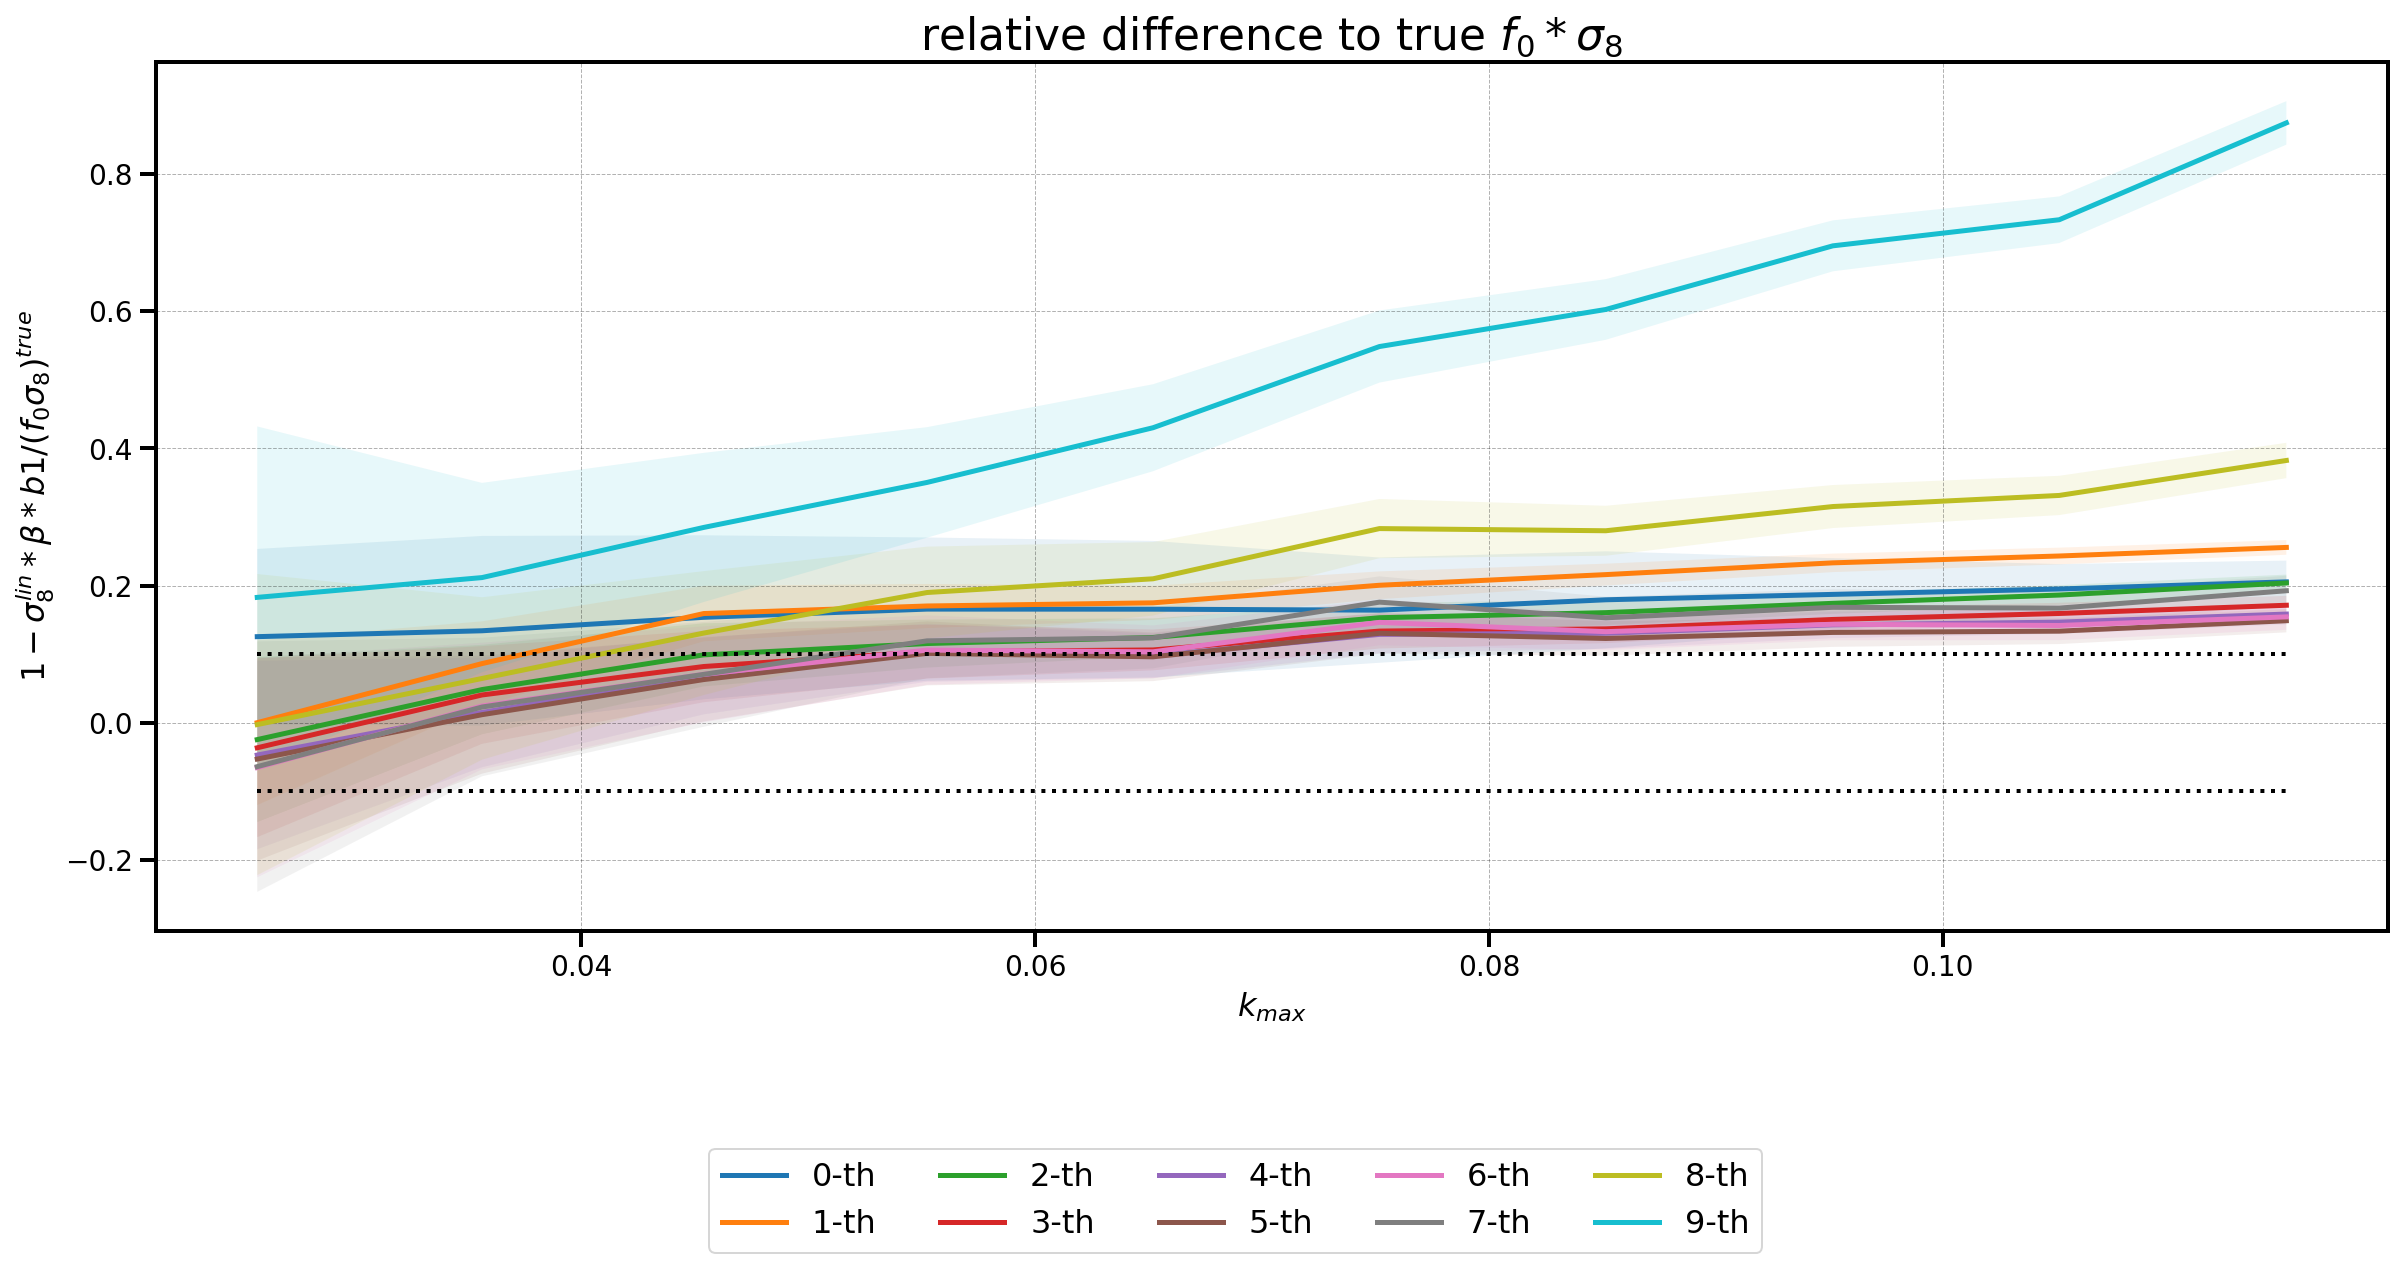

In [29]:
fig = plt.figure(figsize=(20,8))

for i in range(n_ptile):
    plt.plot(kmax_range, delta_fs8[i], label='%d-th'%i)
    plt.fill_between(kmax_range, delta_fs8[i]-delta_fs8_stds[i,:], delta_fs8[i]+delta_fs8_stds[i,:], alpha=0.1)
    
#plt.plot(kmax_range, full_delta_fs8, '--', label='all densities', c='k')
#plt.fill_between(kmax_range, full_delta_fs8-full_delta_fs8_stds, full_delta_fs8+full_delta_fs8_stds, color='k', alpha=0.1)
    
# add 10% diviation lines
plt.hlines([-0.1, 0.1], kmax_range[0], kmax_range[-1], linestyle='dotted', color='k', linewidth=2)

#plt.ylim([-0.2, 0.2])

plt.title(r'relative difference to true $f_0*\sigma_8$')
plt.xlabel(r'$k_{max}$')
plt.ylabel(r'$1 - \sigma_8^{lin}*\beta*b1/(f_0\sigma_8)^{true}$')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=5)
plt.show()

#fig.savefig("plots/Kaiser_dfs8_vs_kmax.pdf")

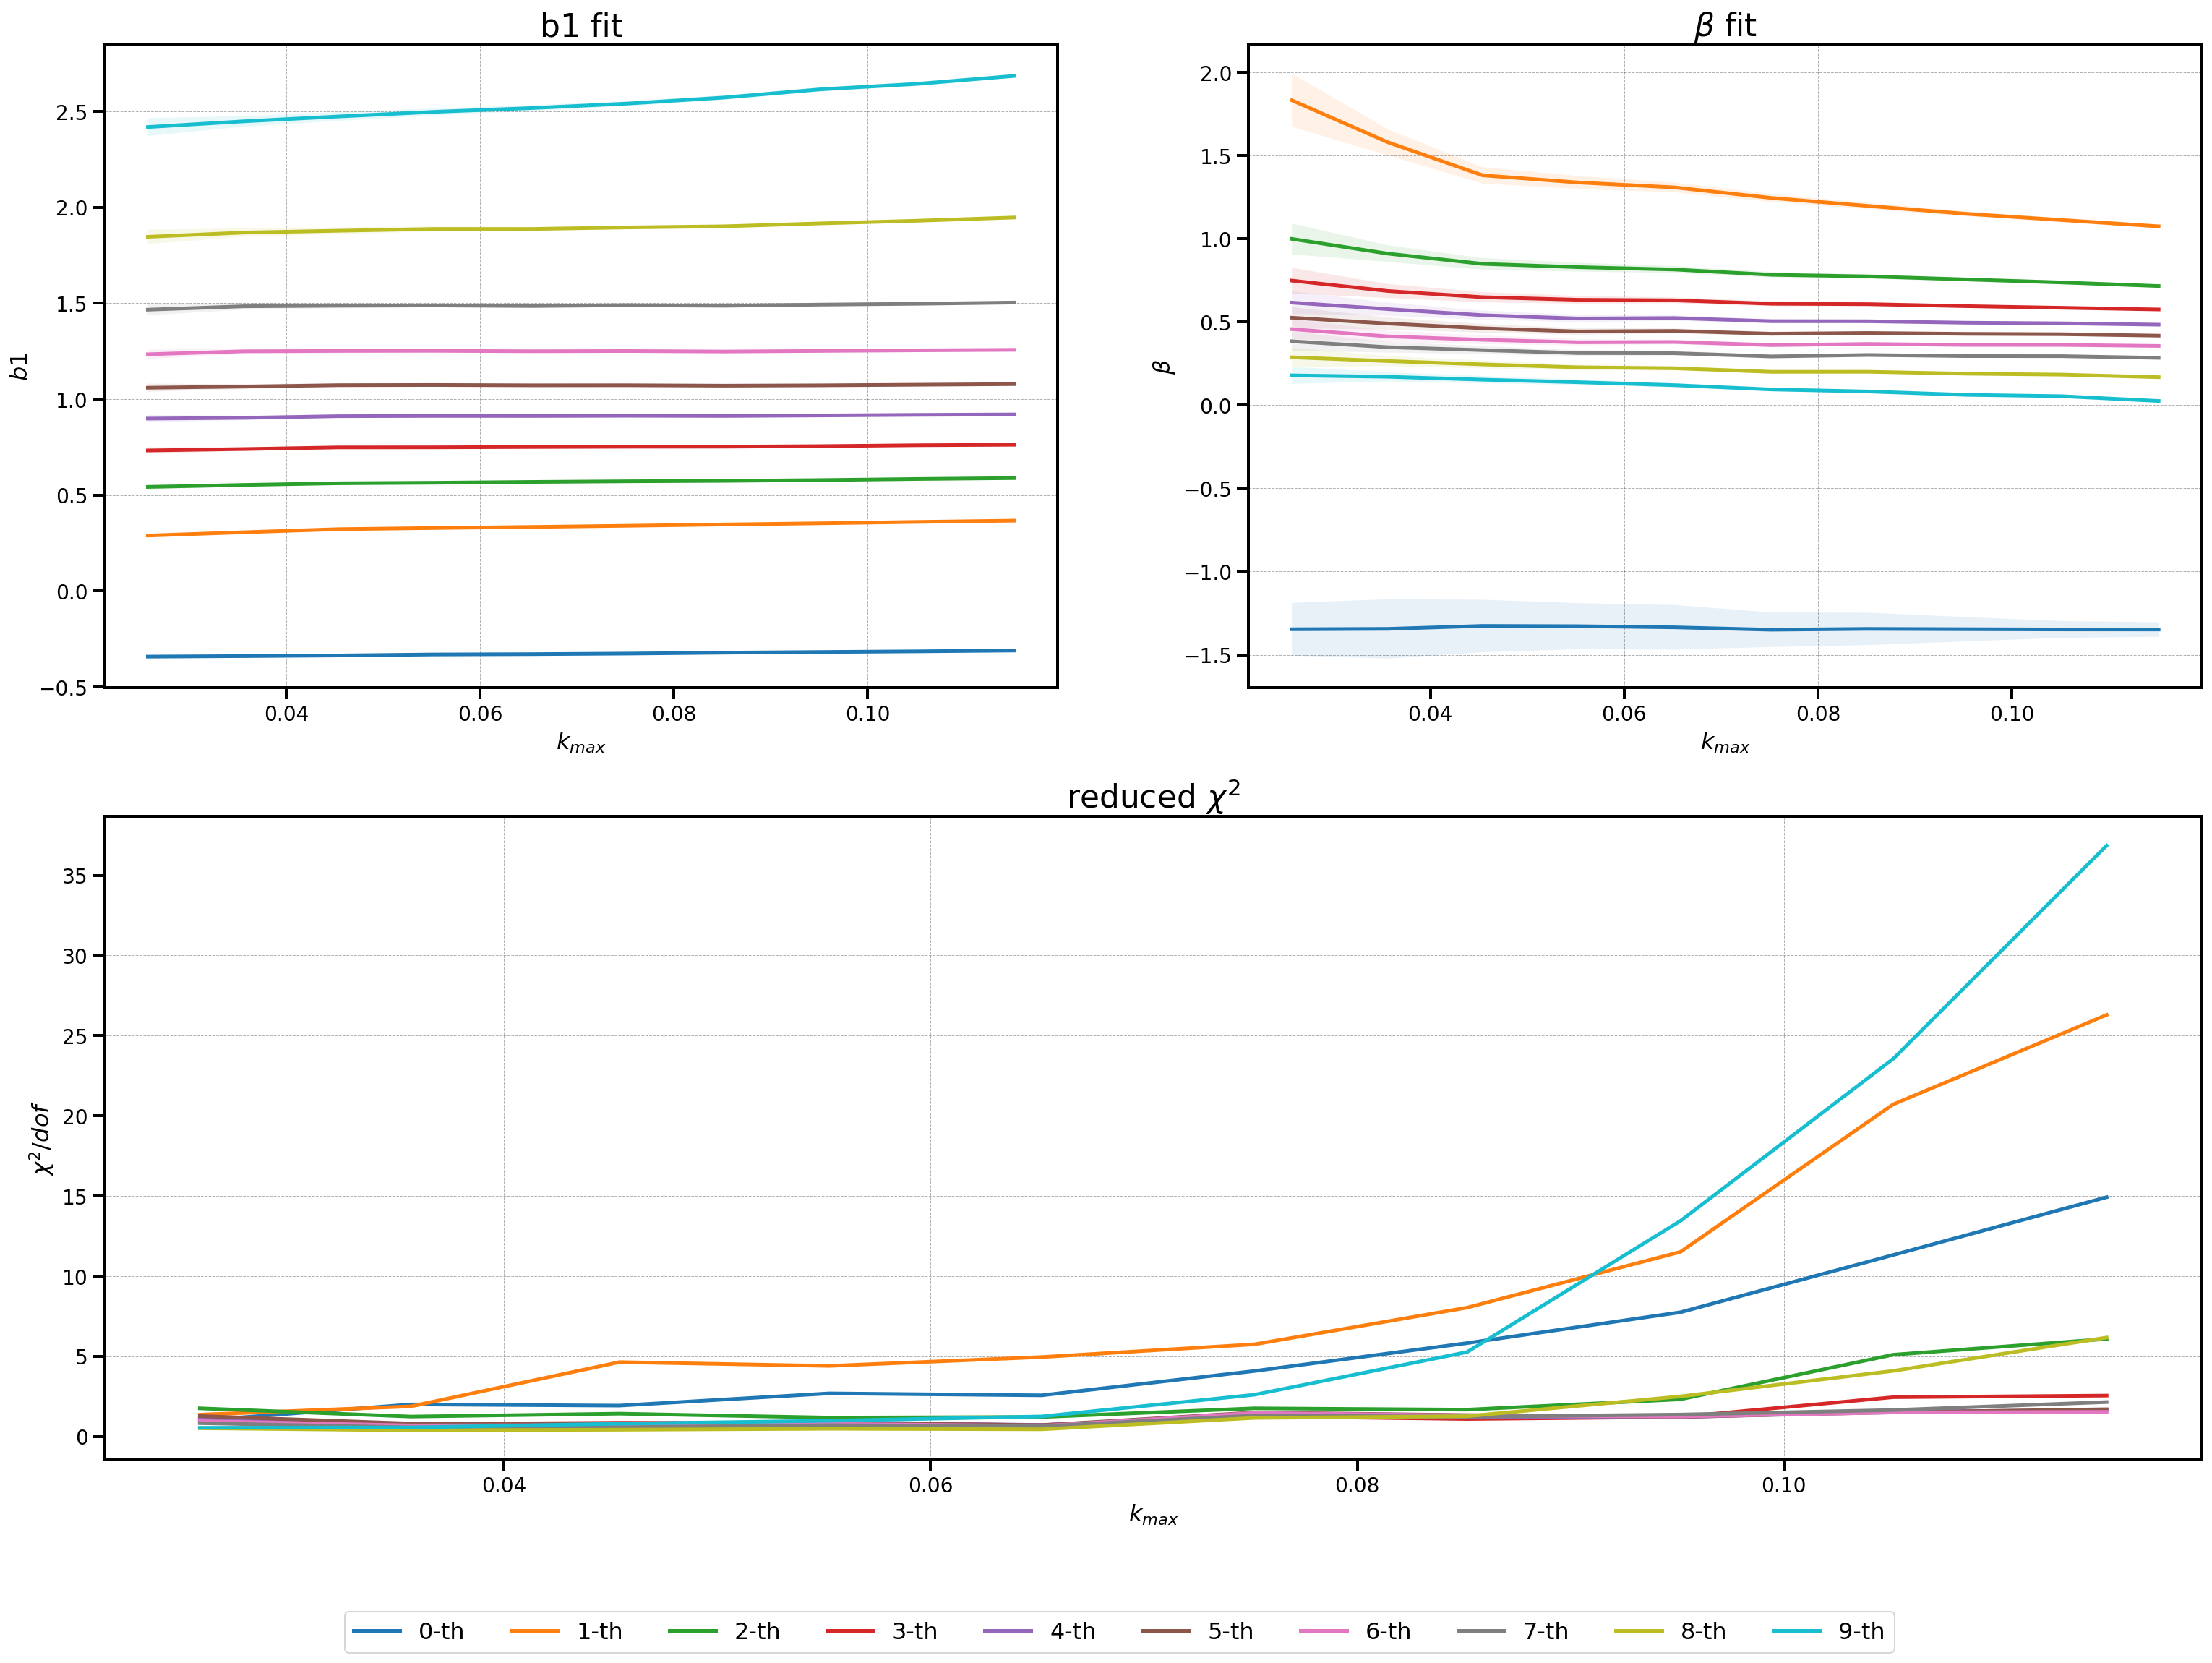

In [20]:
fig = plt.figure(figsize=(26,18))

ax_b1 = plt.subplot(2,2,1)
ax_beta = plt.subplot(2,2,2)
ax_sigma = plt.subplot(2,2,3)
ax_chi2 = plt.subplot(2,2,(3,4))

# ax_b1 = plt.subplot(2,3,1)
# ax_beta = plt.subplot(2,3,2)
# ax_sigma = plt.subplot(2,3,3)
# ax_chi2 = plt.subplot(2,3,(4,6))


for i in range(n_ptile):
    ax_b1.plot(kmax_range, b1_fits[i], label='%d-th'%i)
    ax_b1.fill_between(kmax_range, b1_fits[i]-b1_stds[i], b1_fits[i]+b1_stds[i], alpha=0.1)
    
    ax_beta.plot(kmax_range, beta_fits[i], label='%d-th'%i)
    ax_beta.fill_between(kmax_range, beta_fits[i]-beta_stds[i], beta_fits[i]+beta_stds[i], alpha=0.1)
    
#     ax_sigma.plot(kmax_range, sigma_fits[i], label='%d-th'%i)
#     ax_sigma.fill_between(kmax_range, sigma_fits[i]-sigma_stds[i], sigma_fits[i]+sigma_stds[i], alpha=0.1)
    
    ax_chi2.plot(kmax_range, reduced_chi2[i], label='%d-th'%i)
  

ax_b1.set_title('b1 fit')
ax_b1.set_xlabel(r'$k_{max}$')
ax_b1.set_ylabel(r'$b1$')

ax_beta.set_title(r'$\beta$ fit')
ax_beta.set_xlabel(r'$k_{max}$')
ax_beta.set_ylabel(r'$\beta$')

# ax_sigma.set_title(r'$\sigma$ fit')
# ax_sigma.set_xlabel(r'$k_{max}$')
# ax_sigma.set_ylabel(r'$\sigma$')

ax_chi2.set_title(r'reduced $\chi^2$')
ax_chi2.set_xlabel(r'$k_{max}$')
ax_chi2.set_ylabel(r'$\chi^2 / dof$')

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, +0.05), ncol=n_ptile)

plt.show()
#fig.savefig("plots/Kaiser_fits.pdf")

### Interpretation
As observed in previous analysis steps, bins of extreme density are more difficult to fit with such a simple model than the middle density bins. Hence the agreement of fs8 worse for these bins. From a 'by eye' inspection, we find that the 10% accuracy is surpassed at $kmax \approx 0.06$ the latest. Also, for all bins and all kmax, fs8 is underestimated when not including a Finger of God term.

The ways of dealing with the lowest density bin is described in `Fit_b1_beta_MCMC.ipynb`. 

FoG term $\exp(-(\sigma k \mu)^2)$ corrects Kaiser model by damping it. The size of $\sigma$ determines the maximal size of k after which the FoG term and thus the power spectrum go to zero.